<a href="https://colab.research.google.com/github/doorapr/dllab/blob/main/finding_mask_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    #!mkdir images
    #!wget -r images https://github.com/doorapr/dllab/cropped_original_hd8_wheel
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-98m3vcui
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-98m3vcui
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=5e8980edc75ef035e1b81774d2ed8df8f35dc7347684c43bb1f09271c714eddb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vidqtvy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-11 11:19:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.10, 

In [6]:
!unzip /content/cropped_original_hd8_wheel.zip

Archive:  /content/cropped_original_hd8_wheel.zip
   creating: cropped_original_hd8_wheel/
  inflating: __MACOSX/._cropped_original_hd8_wheel  
  inflating: cropped_original_hd8_wheel/000003-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000003-img.jpg  
  inflating: cropped_original_hd8_wheel/000013-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000013-img.jpg  
  inflating: cropped_original_hd8_wheel/000010-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000010-img.jpg  
  inflating: cropped_original_hd8_wheel/000009-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000009-img.jpg  
  inflating: cropped_original_hd8_wheel/000008-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000008-img.jpg  
  inflating: cropped_original_hd8_wheel/000018-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/._000018-img.jpg  
  inflating: cropped_original_hd8_wheel/000001-img.jpg  
  inflating: __MACOSX/cropped_original_hd8_wheel/

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [9]:
image = cv2.imread('/content/cropped_original_hd8_wheel/000001-img.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#img = cv2.imread('your file name')

height = image.shape[0]
width = image.shape[1]


In [ ]:
#original_img = cv2.imread('part1.jpg')
#original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#recon_img = cv2.imread('part2.jpg')
#recon_img = cv2.cvtColor(recon_img, cv2.COLOR_BGR2RGB)

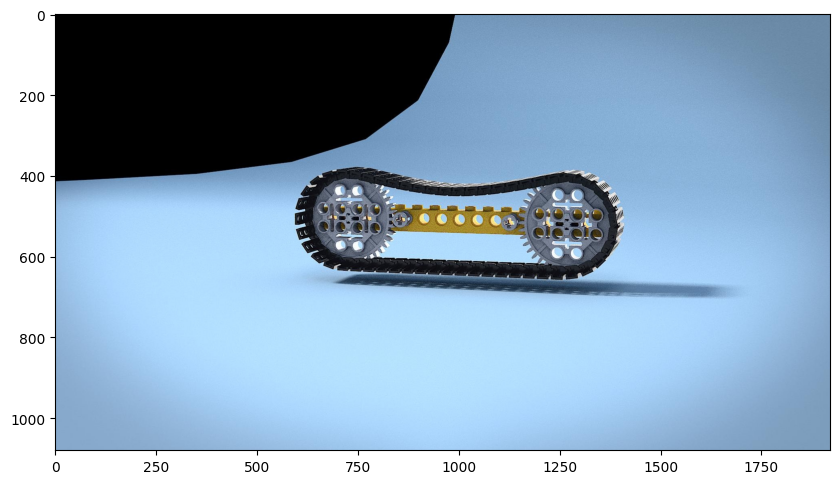

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [13]:
predictor.set_image(image)

In [72]:
input_point = np.array([[640, 500]])
input_label = np.array([1])

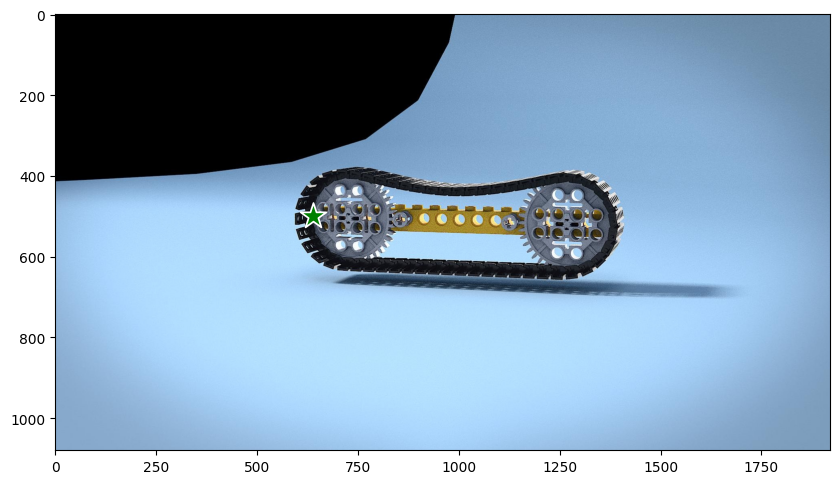

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [74]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [75]:
masks.shape  # (number_of_masks) x H x W

(3, 1080, 1920)

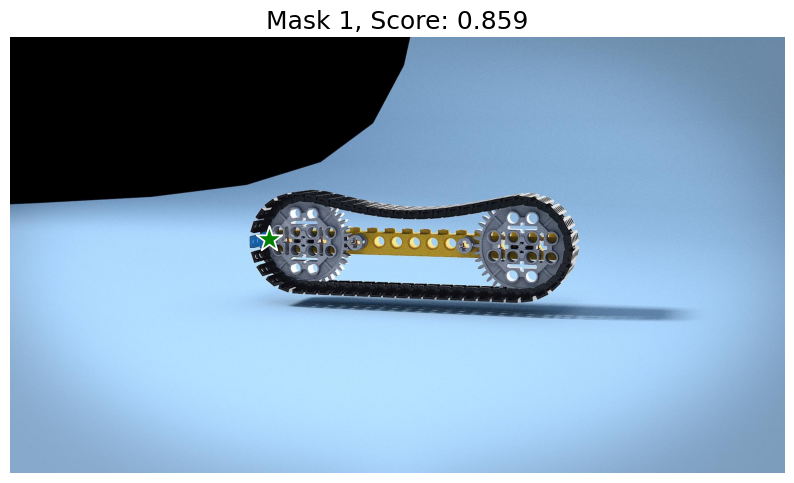

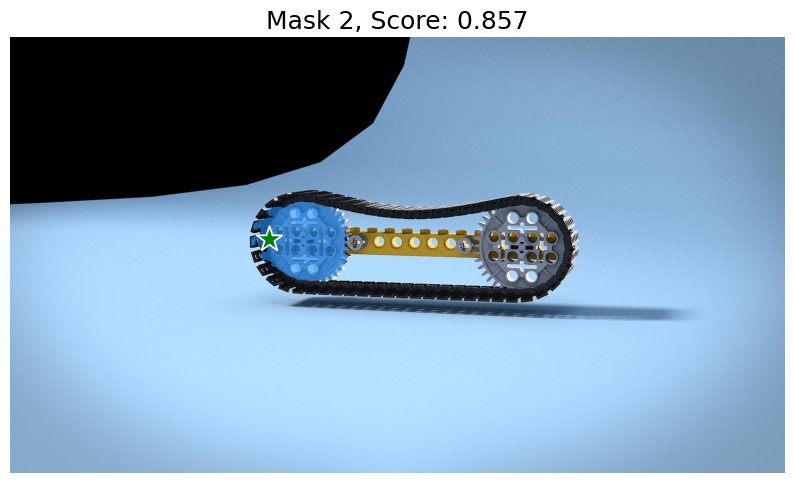

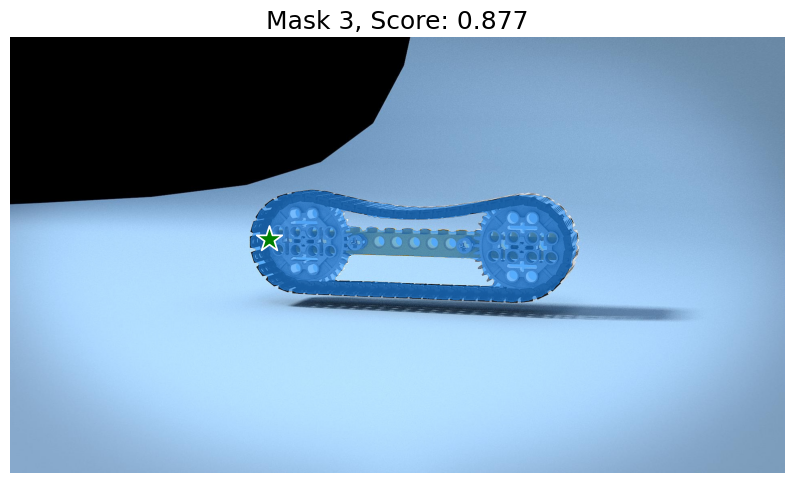

In [76]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [77]:
input_point = np.array([[640, 500], [1300, 500]])
input_label = np.array([1, 1])
best_mask=2
print(np.argmax(scores))
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
mask_input.shape

2


(256, 256)

In [78]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)


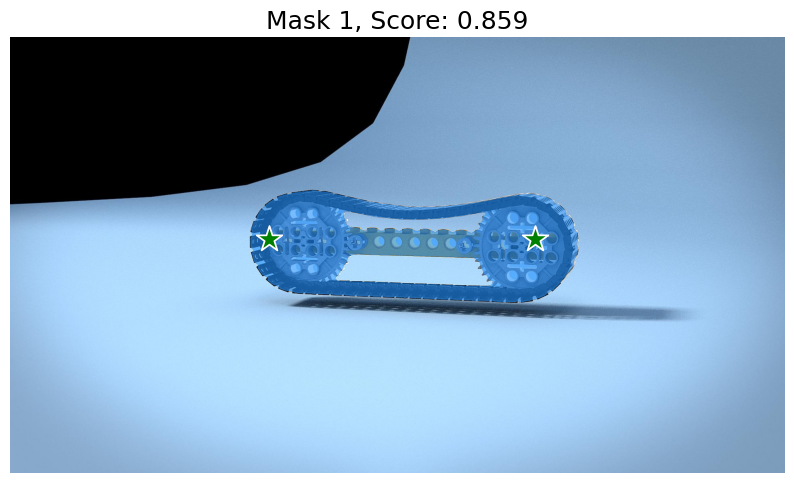

In [79]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [82]:
#f = open("mask_1.txt", "x")
f = open("mask_1.txt", "w")
f.write(str(masks))
f.close()
